### Case Study 4.1 - Movies

#### Identification Information

* Name: Jaime Arroyo Leon
* User: Jarroyo
* Email: jaime.arroyo@hdi.cl

#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate, KFold, GridSearchCV

#### Data

In [2]:
# Carga de dataset movielens
data = Dataset.load_builtin('ml-100k')

We also want to get a sense of what the data looks like. Please create a histogram of all the ratings we have in the dataset.

In [3]:
#Usando pandas para visualizar la data
movies = pd.read_csv('u.data.txt',sep='\t', header=None)
movies.columns = ['user', 'item', 'rating', 'timestamp']
movies.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies.describe()

,user,item,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


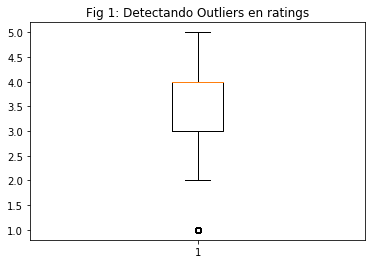

In [5]:
%matplotlib inline
plt.boxplot(movies['rating'])
plt.title('Fig 1: Detectando Outliers en ratings')
plt.show()

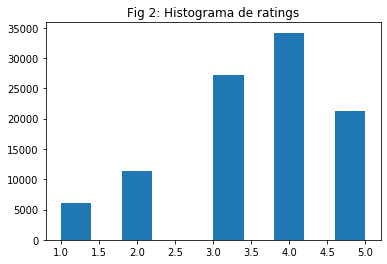

In [6]:
#Generacion del histograma para visualizar la cantidad de ratings
plt.hist(movies['rating'])
plt.title('Fig 2: Histograma de ratings')
plt.show()

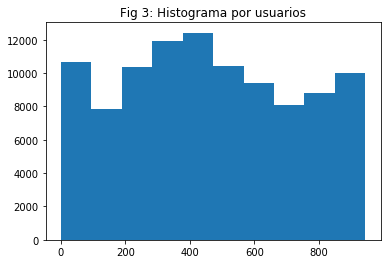

In [7]:
#Distribucion de las valoraciones por usuario
plt.hist(movies['user'])
plt.title('Fig 3: Histograma por usuarios')
plt.show()

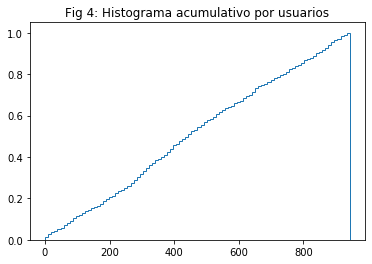

In [8]:
# Cumulative Histogram
n_bins = 100
plt.hist(movies['user'], n_bins, density=True, histtype='step',
                           cumulative=True)
plt.title('Fig 4: Histograma acumulativo por usuarios')
plt.show()

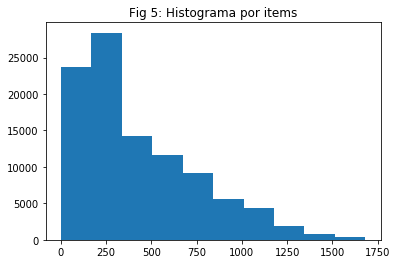

In [9]:
#Distribucion de las valoraciones por peliculas
plt.hist(movies['item'])
plt.title('Fig 5: Histograma por items')
plt.show()

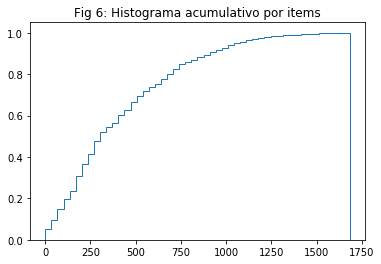

In [10]:
# Cumulative Histogram
n_bins = 50
plt.hist(movies['item'], n_bins, density=True, histtype='step',
                           cumulative=True)
plt.title('Fig 6: Histograma acumulativo por items')
plt.show()

In [11]:
#Frecuencia por cada ratings
print('total ratings: {}'.format(len(movies['rating'])))
print('Agrupado por valoracion')
movies['rating'].value_counts(normalize=True)*100

total ratings: 100000
Agrupado por valoracion


4    34.174
3    27.145
5    21.201
2    11.370
1     6.110
Name: rating, dtype: float64

<h4 style="color:red;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many ratings are in the dataset? How would you describe the distribution of ratings? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

* Podemos observar que el 82.52% de las valoraciones se encuentran entre 3 y 5 dejando un 17,48% para valoraciones 1 y 2. Si consideramos esta distribución para realizar el entrenamiento del modelo, se cuenta con una distribucion cercana al 80% a valoraciones positivas y un 20% a valoraciones negativas. Contamos con 100.000 valoraciones dentro del dataset cuyo promedio se encuentra en 3.53(4). Luego de aplicar boxplot para observar graficamente como se distribuyen los cuantiles de la data, es posible apreciar que la valoracion = 1, se podria considerar poco comun dentro de este dataset puesto que solo comprende el menos del 6% de los datos.

#### Model 1: Random

* Modelo que genera una prediccion aleatoria en funcion de la distribucion de la data de entrenamiento asumiendo que se distribuye N(μ,σ^2) el cual utiliza la estimacion de maxima verosimilitud para encontrar la media y la std

In [12]:
#Dividiendo el dataset en 80% entrenamiento, 20% testing
train_set, test_set = train_test_split(data,test_size=.2, random_state=42, shuffle=True)

In [13]:
# Create model using NormalPredictor() class
rdm_predict = NormalPredictor()
rdm_predict.fit(train_set)

In [14]:
test_pred = rdm_predict.test(test_set)
accuracy.rmse(test_pred)

RMSE: 1.5164


1.5163784907443556

In [15]:
# Train on data using cross-validation with k=5 folds, measuring the RMSE
cv = cross_validate(rdm_predict, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5307  1.5139  1.5153  1.5261  1.5225  1.5217  0.0064  
MAE (testset)     1.2327  1.2177  1.2154  1.2240  1.2235  1.2226  0.0060  
Fit time          0.15    0.16    0.17    0.12    0.13    0.15    0.02    
Test time         0.25    0.14    0.16    0.11    0.17    0.17    0.05    


#### Model 2: User-Based Collaborative Filtering

* Realizar GridSearchCV para encontrar los mejores parametros del algoritmo

In [16]:
param_grid = {'k': [23,24,25],
              'sim_options': {'user_based': [True]} #User_based
              }

In [17]:
gscv = GridSearchCV(KNNBasic, param_grid, measures=['rmse','mae'], cv=5, n_jobs=-1)

In [18]:
gscv.fit(data)

In [19]:
# Mejor RMSE
print('RMSE Score: {}'.format(gscv.best_score['rmse']))
# Parametros que minimizan RMSE
print('Parametros: {}'.format(gscv.best_params['rmse']))

RMSE Score: 0.975616702335109
Parametros: {'k': 25, 'sim_options': {'user_based': True}}


In [20]:
# Create model using KNNBasic() class
knn = KNNBasic(k = 24, sim_options={'user_based': [True]}) #User_based permite configurar si se usara user-user o item-item

In [21]:
# Train using same cross validation code as above
cv = cross_validate(knn, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9749  0.9776  0.9804  0.9728  0.9705  0.9753  0.0035  
MAE (testset)     0.7683  0.7697  0.7749  0.7661  0.7670  0.7692  0.0031  
Fit time          0.50    0.61    0.53    0.58    0.59    0.56    0.04    
Test time         4.31    3.94    3.15    3.24    4.06    3.74    0.46    


#### Model 3: Item-Based Collaborative Filtering

In [22]:
param_grid = {'k': [35,40,45],
              'sim_options': {'user_based': [False]} #Item-Based
              }

In [23]:
gscv = GridSearchCV(KNNBasic, param_grid, measures=['rmse','mae'], cv=5, n_jobs=-1)

In [24]:
gscv.fit(data)

In [25]:
# Mejor RMSE
print('RMSE Score: {}'.format(gscv.best_score['rmse']))
# Parametros que minimizan RMSE
print('Parametros: {}'.format(gscv.best_params['rmse']))

RMSE Score: 0.9742756898379292
Parametros: {'k': 40, 'sim_options': {'user_based': False}}


In [26]:
# Create model using KNNBasic() class
knn = KNNBasic(k = 40, sim_options={'user_based': [False]})

In [27]:
# Train using same cross validation code as above
cv = cross_validate(knn, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9853  0.9795  0.9775  0.9806  0.9754  0.9797  0.0033  
MAE (testset)     0.7794  0.7738  0.7739  0.7719  0.7698  0.7738  0.0032  
Fit time          0.50    0.45    0.48    0.42    0.44    0.46    0.03    
Test time         3.03    2.92    2.83    2.84    2.90    2.90    0.07    


<h4 style="color:red;">QUESTION 2: COLLABORATIVE FILTERING MODELS</h1>

**Compare the results from the user-user and item-item models. How do they compare to each other? How do they compare to our original "random" model? Can you provide any intuition as to why the results came out the way they did?**

* Random model rmse (test_data): 1.52
* Collaborative Filtering (User_based) rmse (test_data): 0.9753
* Collaborative Filtering (Item_based) rmse (test_data): 0.9797

* Si bien ambos modelos (Filtering Collaborative) presentan RMSE similares, el modelo user_based obtuvo un mejor resultado sobre las predicciones en el testing dataset. Ademas de utilizar menor cantidad de vecinos (k) para predecir, lo cual ayuda en el tiempo de procesamiento, la distribucion acumulativa que presenta la valoracion por usuarios segun la Fig. 4, permite apreciar que a diferencia de las peliculas (distribucion en Fig. 5 y Fig. 6), hay una muestra mas homogenea de valoraciones por cada usuario. En la Fig. 5 se percibe como solo algunas peliculas reciben grandes cantidades de valoraciones concentrando la informacion solo en algunos puntos de datos y no en todos los usuarios como lo permite el user-based.
* A diferencia del Random model el cual entrega predicciones de acuerdo a la distribucion de la base de entrenamiento, donde vemos que hay un 80% de valoraciones sobre 3, es muy probable que falle en ratings bajos aumentando el RMSE como se muestra en los resultados, el algoritmo de KNN en ambos metodos, utiliza los k vecinos mas cercanos al punto de dato a predecir, utilizando la distancia coseno promedio para predecir la valoracion que recibira una pelicula dadas las valoraciones por realizadas por los usuarios o viceversa el cual permite tener una mejora del 56% en las predicciones.

#### Model 4: Matrix Factorization

In [28]:
param_grid = {'n_factors': [120,130,140],
              'n_epochs': [25,30],
              'lr_all': [0.007, 0.01, 0.015],
              'reg_all': [0.07, 0.1, 0.15] 
              }

In [29]:
gscv = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=5, n_jobs=-1)

In [30]:
gscv.fit(data)

In [31]:
# Mejor RMSE
print('RMSE Score: {}'.format(gscv.best_score['rmse']))
# Parametros que minimizan RMSE
print('Parametros: {}'.format(gscv.best_params['rmse']))

RMSE Score: 0.9110369838163468
Parametros: {'n_factors': 120, 'n_epochs': 30, 'lr_all': 0.015, 'reg_all': 0.1}


In [32]:
# Create model using SVD() class
svd = SVD(n_factors = 130, n_epochs = 30, lr_all = 0.015, reg_all = 0.1)

In [33]:
# Train using same cross validation code as above
cv = cross_validate(svd, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9010  0.9139  0.9111  0.9125  0.9103  0.9097  0.0045  
MAE (testset)     0.7134  0.7229  0.7198  0.7211  0.7207  0.7196  0.0033  
Fit time          7.34    7.53    7.66    7.44    7.49    7.49    0.10    
Test time         0.11    0.15    0.11    0.16    0.12    0.13    0.02    


<h4 style="color:red;">QUESTION 3: MATRIX FACTORIZATION MODEL</h1>

**The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE again. Does it improve? Can you offer any reasoning as to why that might be?**

* De acuerdo al texto Probabilistic Matrix Factorization de Ruslan Salakhutdinov and Andriy Mnih - Department of Computer Science, University of Toronto, el modelo SVD o Matrix Factorization Model puede generalizar considerablemente mejor para usuarios con muy pocas calificaciones y en datasets grandes con distribuciones como las que presenta Movielens. Mediante el algoritmo cuyo objetivo es minimizar la suma de las distancias al cuadrado de la matriz R (N usuarios x M peliculas) utilizando SGD obteniendo en "one-shot" la prediccion para la formula R = M ∑ U.t rellenando las valoraciones para cada pelicula y usuario, permite obtener hasta ahora el mejor resultado en RMSE con 0.9096 vs 0.976 y 0.9804 respectivamente en los modelos de filtro colaborativo. A diferencia de estos modelos, implicitamente el modelo SVD utiliza las valoraciones generadas tanto por usuarios como peliculas, iterando una n_epochs cantidad de veces hasta minimizar el error en el set de entrenamiento permitiendo asi una mejora de un %7,18 respecto a los filtros colaborativos.

#### Precision and Recall @ `k`

* We now want to compute the precision and recall for 2 values of `k`: 5 and 10. We have provided some code here to help you do that.
* First, we define a function that takes in some predictions, a value of `k` and a threshold parameter. This code is adapted from [here](http://surprise.readthedocs.io/en/stable/FAQ.html?highlight=precision#how-to-compute-precision-k-and-recall-k).

In [34]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

<h4 style="color:red;">QUESTION 4: PRECISION/RECALL</h1>

**Compute the precision and recall, for each of the 4 models, at `k` = 5 and 10. This is 2 x 2 x 4 = 16 numerical values. Do you note anything interesting about these values? Anything differerent from the RMSE values you computed above?**

Some code is required for this question.

#### Resumen de cada Modelo y Calculo de Precision y Recall

In [35]:
models = [
    NormalPredictor(), # assume normal distribution
    KNNBasic(k = 24, sim_options={'user_based': [True]}),
    KNNBasic(k = 40, sim_options={'user_based': [False]}),
    SVD(n_factors = 130, n_epochs = 30, lr_all = 0.015, reg_all = 0.1),
]

In [36]:
print('Precision y Recall for k = 5')
for i in models:
    print('Modelo: {}'.format(i))
    i.fit(train_set)
    predictions = i.test(test_set)
    accuracy.rmse(predictions)
    
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    
    # Precision and recall can then be averaged over all users
    print('Precision-5:')
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall-5:')
    print(sum(rec for rec in recalls.values()) / len(recalls))
    print(' ')

Precision y Recall for k = 5
Modelo: <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001A313E0C860>
RMSE: 1.5294
Precision-5:
0.5924113475177318
Recall-5:
0.33828234927127243
 
Modelo: <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001A313E0CB38>
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765
Precision-5:
0.7626063829787232
Recall-5:
0.4488859767228029
 
Modelo: <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001A313E0C6A0>
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802
Precision-5:
0.7701418439716313
Recall-5:
0.45542695248924264
 
Modelo: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001A313E0C828>
RMSE: 0.9124
Precision-5:
0.8176950354609925
Recall-5:
0.4443015548888216
 


In [37]:
print('Precision y Recall for k = 10')
for i in models:
    print('Modelo: {}'.format(i))
    i.fit(train_set)
    predictions = i.test(test_set)
    rmse = accuracy.rmse(predictions)
    
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)
    
    # Precision and recall can then be averaged over all users
    print('Precision-5:')
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall-5:')
    print(sum(rec for rec in recalls.values()) / len(recalls))
    print(' ')

Precision y Recall for k = 10
Modelo: <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001A313E0C860>
RMSE: 1.5309
Precision-5:
0.5777060114826071
Recall-5:
0.42169993193686
 
Modelo: <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001A313E0CB38>
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765
Precision-5:
0.7398020094562645
Recall-5:
0.5869358006756487
 
Modelo: <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001A313E0C6A0>
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802
Precision-5:
0.7474658054711246
Recall-5:
0.5922889757773129
 
Modelo: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001A313E0C828>
RMSE: 0.9115
Precision-5:
0.7956940222897654
Recall-5:
0.5814258550402731
 


* Respuestas: Es posible ver como la precision aumenta directamente proporcional de acuerdo a RMSE de cada modelo, donde el SVD es el modelo cuya precision (80% k=5, 79% k=10) es el que mejor predice para este dataset. Respecto al Recall, dado que concentramos el calulo en los k-primeras mejores valoraciones, y como el score es calculado no tendra mayor variacion al respecto y no aporta mayor informacion para estras clasificaciones. Si bien, para el k-10, las precisiones caen dado que se aumenta la muestra, la variacion tiende a estar entre un %2.7 para los filtros colaborativos y %3.8 para SVD (NormalPredictor no sufre mayor variacion, sin embargo, su precision es de 60%)
* Los RMSE se comportan de igual manera como vimos en la etapa de Cross-Validation.

#### Top-`n` Predictions

Finally, we can see what some of the actual movie ratings are for particular users, as outputs of our model.

Again, we define a helpful function.

In [38]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Then, we call this function on each of our models, first training on **all** the data we have available, then predicting on the remaining, missing data. We use `n`=5 here, but you can pick any reasonable value of `n` you would like.

This may take some time to compute, so be patient.

Hint: Use [`**Dataset.build_full_trainset**`](http://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset) to get the full trainset from the data. Then call [`**Trainset.build_anti_testset**`](http://surprise.readthedocs.io/en/stable/trainset.html#surprise.Trainset.build_anti_testset) to get the testset out. Finally, `fit` on the trainset, `test` on the testset, then pass that result to our `get_top_n` function.

<h4 style="color:red;">QUESTION 5: TOP N PREDICTIONS</h1>

**Do the top n predictions that you received make sense? What is the rating value (1-5) of these predictions? How could you use these predictions in the real-world if you were trying to build a generic content recommender system for a company?**

Some code is required for this question.

In [70]:
#Entrenamiento de todos los modelos y sus top-n predicciones
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

for i in models:
    print('Modelo: {}'.format(i))
    
    i.fit(trainset)
    predictions = i.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Items recomendados para cada usuario
    print('Top-5 predicciones')
    top_n = pd.DataFrame(top_n)
    top_n = top_n.transpose()
    top_n.columns = ['Pelicula 1', 'Pelicula 2', 'Pelicula 3', 'Pelicula 4',  'Pelicula 5' ]
    print(top_n.head(10))
    print(' ')
    


Modelo: <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001A313E0C860>
Top-5 predicciones
    Pelicula 1 Pelicula 2 Pelicula 3 Pelicula 4 Pelicula 5
196   (222, 5)   (277, 5)   (181, 5)   (232, 5)  (1049, 5)
186   (242, 5)    (51, 5)   (222, 5)    (40, 5)   (144, 5)
22     (95, 5)   (304, 5)   (564, 5)   (219, 5)   (496, 5)
244   (277, 5)  (1081, 5)     (4, 5)   (322, 5)   (416, 5)
166   (302, 5)   (377, 5)   (327, 5)   (201, 5)  (1137, 5)
298   (302, 5)    (32, 5)   (332, 5)   (232, 5)   (416, 5)
115   (222, 5)  (1184, 5)   (144, 5)   (564, 5)   (332, 5)
253   (486, 5)   (564, 5)   (241, 5)   (219, 5)    (26, 5)
305    (40, 5)   (432, 5)   (498, 5)   (832, 5)  (1147, 5)
6     (377, 5)   (346, 5)    (29, 5)  (1184, 5)   (144, 5)
 
Modelo: <surprise.prediction_algorithms.knns.KNNBasic object at 0x000001A313E0CB38>
Computing the msd similarity matrix...
Done computing similarity matrix.
Top-5 predicciones
    Pelicula 1 Pelicula 2 Pelicula 3 Pelicula 4 Pelicula

##### Matriz de similaridad entre usuarios

In [110]:
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [98]:
n_users = movies.user.unique().shape[0]
n_users

943

In [99]:
n_items = movies.item.unique().shape[0]
n_items

1682

In [108]:
#Creacion de matriz usuario - items buscando en df si tiene valoracion.
ratings = np.zeros((n_users, n_items))
for row in movies.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [113]:
rating_train, rating_test = train_test_split(ratings, test_size=0.2, random_state=42)
print(rating_train.shape)
print(rating_test.shape)

(754, 1682)
(189, 1682)


In [151]:
# Matriz de similaridad entre usuarios
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(rating_train)
sim_matrix = pd.DataFrame(sim_matrix)
#Similaridad de un usuario especifico (id 196-1)
sim_matrix.iloc[195,:].sort_values(ascending = False).head(10)

195    1.000000
94     0.428364
179    0.399669
501    0.391761
635    0.364574
278    0.359926
206    0.359455
5      0.345600
16     0.344436
473    0.340263
Name: 195, dtype: float64

In [199]:
#Peliculas mejor valoradas por usuario 94, similar al usuario 196
user_94 = movies[movies.user==94]
movies_user_94 = user_94.sort_values(by=['rating'],ascending=False)

In [200]:
movies_user_94.head()

,user,item,rating,timestamp
73555,94,357,5,891720921
87556,94,631,5,891720950
15775,94,448,5,891722939
33599,94,549,5,891721528
86787,94,127,5,885870175


In [203]:
movies_user_94 = movies_user_94.merge(movies_names[['movieId','title']], left_on='item', right_on='movieId', how='left').drop('movieId', axis=1)
movies_user_94.head()

,user,item,rating,timestamp,title
0,94,357,5,891720921,Four Weddings and a Funeral (1994)
1,94,631,5,891720950,All Dogs Go to Heaven 2 (1996)
2,94,448,5,891722939,Fearless (1993)
3,94,549,5,891721528,Thirty-Two Short Films About Glenn Gould (1993)
4,94,127,5,885870175,NaN


In [209]:
#El usuario 94 valoro con nota 5, dos de las 5 peliculas recomendadas al usuario 196
#print(movies_user_94[movies_user_94.item==1449])
print(movies_user_94[movies_user_94.item==318])
print(movies_user_94[movies_user_94.item==64])
#print(movies_user_94[movies_user_94.item==1642])
#print(movies_user_94[movies_user_94.item==1524])

    user  item  rating  timestamp                             title
78    94   318       5  891721191  Shawshank Redemption, The (1994)
    user  item  rating  timestamp                 title
72    94    64       5  885870362  Two if by Sea (1996)


##### Cargar nombre de peliculas

In [201]:
movies_names = pd.read_csv('../Caso estudio 4.1 Sistema de recomendacion/Ayuda/ml-latest-small/movies.csv')
movies_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* Las top 5 predicciones por cada usuario, se encuentran con ratings >= 4. Si bien, no soy un experto en peliculas, se ve que las recomendaciones para los usuarios tienen sentido, esto comprobado solo con 1 ejemplo al tomar el primer usuario ID: 196 y buscar en la matriz de similaridad bajo distancia coseno al más parecido ID: 94, de las cuales dos de las peliculas recomendadas por el modelo, fueron vistas por el usario 94 y valoradas con nota 5 por lo que afirma que el modelo a priori esta prediciendo bastante bien (podria seguir con el analisis en detalle pero eso tomaria algo de tiempo). Utilizando este metodo, pienso aplicarlo dentro de mi organizacion utilizando el comportamiento de los usuarios dentro del sitio web de compra, con alguna aplicacion que vaya generando un dataset de acuerdo a los clicks, movimientos de mouse, etc. y con ello realizar recomendaciones de productos de acuerdo a la data historica y las compras realizadas previamente por los clientes. Bajo mi punto de vista, el modelo que se comporta de mejor manera es SVD dado que los otros modelos dada su construccion entregan predicciones con nota 5.

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@4.1_instruction_manual.html) to wrap up this case study properly.